In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np    

from sklearn.neighbors import KNeighborsClassifier
from lightgbm import  LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from scipy.stats import chi2_contingency 

from preprocess import separate, extra_features
from pipelines import preprocessor, preprocessor2

In [2]:
def chi(data):
    col_drop=[]
    
    for col in data.columns:
        
        ct=pd.crosstab(y, data[col])
        chi2, p, _, _ =chi2_contingency(ct)
        
        if p >= 0.05:
            col_drop.append(col)
        elif chi2 <= 3000:
            col_drop.append(col)
            
    return col_drop

In [3]:
train= pd.read_csv("Datasets\Train.csv") 
train=extra_features(train)
X=train.drop('cost_category', axis=1)
y=train['cost_category']
col_drop=chi(train)
X.drop(columns=col_drop, inplace=True)
print(f"X: {X.shape}\ny: {y.shape}")

X: (18506, 16)
y: (18506,)


In [4]:
X1=preprocessor(X)
X2=preprocessor2(X)
print(f"X1: {X1.shape}\nX2: {X2.shape}")

X1: (18506, 177)
X2: (18506, 47)


In [5]:
le=LabelEncoder()
y=le.fit_transform(y)
y.shape

(18506,)

In [6]:
models= {
    "KNN": KNeighborsClassifier(n_neighbors=5, weights="uniform", algorithm="auto"),
    "SVM": SVC(gamma='auto', C= 100),
    "GBM": LGBMClassifier(n_estimators=200, learning_rate=0.01),
    "XGB": XGBClassifier(n_estimators=200, learning_rate=0.01),
    "Forest": RandomForestClassifier(max_depth=8),
    "Tree": DecisionTreeClassifier(max_depth=8),
}


samples={
    "X1": X1,
    "X2": X2,
}

In [7]:
kfolds=StratifiedKFold(n_splits=10,shuffle=True)

def strat(modell, sample, y, kfold):

    results= {}

    results['model_name']=modell+"_"+sample
    
    
    model=models[modell]
    X= samples[sample]
    
    for fold, (train_idx, val_idx) in enumerate(kfolds.split(X,y)):
        X_train, X_test=X[train_idx], X[val_idx]
        y_train, y_test=y[train_idx], y[val_idx]
    
        model.fit(X_train, y_train)
    
        y_pred=model.predict(X_test)
        
        results["Fold_{}".format(fold+1)]=f1_score(y_pred, y_test, average='weighted')
        #results['mean']=results.mean(axis=1)
    
    #df= pd.DataFrame(results)   
    return results

In [8]:
all_models=[]

for model in models:
    for X in samples:
        all_models.append(strat(model, X, y, kfolds))
        print(f"Model: {model}_{X}......\n")

Model: KNN_X1......

Model: KNN_X2......

Model: SVM_X1......

Model: SVM_X2......

Model: GBM_X1......

Model: GBM_X2......

Model: XGB_X1......

Model: XGB_X2......

Model: Forest_X1......

Model: Forest_X2......

Model: Tree_X1......

Model: Tree_X2......



In [9]:
models_df=pd.DataFrame(all_models)
models_df.dropna(axis=1, inplace=True)
models_df['av_score']=models_df.loc[:,"Fold_1":"Fold_10"].sum(axis=1)*100/10
models_df

,model_name,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,Fold_6,Fold_7,Fold_8,Fold_9,Fold_10,av_score
0,KNN_X1,0.495034,0.534703,0.495302,0.516410,0.509762,0.500539,0.509440,0.512816,0.513302,0.492455,50.797632
1,KNN_X2,0.492366,0.496229,0.487402,0.506722,0.519098,0.504681,0.489394,0.511123,0.508496,0.507349,50.228592
2,SVM_X1,0.595854,0.593720,0.616108,0.593170,0.587730,0.591197,0.597387,0.602148,0.610298,0.609485,59.970974
3,SVM_X2,0.564764,0.567849,0.537278,0.561552,0.567447,0.544411,0.559519,0.534019,0.579582,0.546044,55.624636
4,GBM_X1,0.623283,0.606471,0.618282,0.633915,0.613488,0.622841,0.605489,0.615931,0.604257,0.595538,61.394960
5,GBM_X2,0.614124,0.617096,0.612562,0.599365,0.614811,0.619742,0.604063,0.607009,0.601098,0.607423,60.972932
6,XGB_X1,0.623370,0.606985,0.604929,0.597506,0.608170,0.626338,0.605791,0.622513,0.600951,0.606565,61.031196
7,XGB_X2,0.601493,0.617062,0.610448,0.621044,0.599613,0.599325,0.596463,0.623725,0.577956,0.611842,60.589695
8,Forest_X1,0.611976,0.592035,0.601033,0.596198,0.601352,0.574873,0.579666,0.601433,0.600976,0.605260,59.648010
9,Forest_X2,0.600786,0.595518,0.604305,0.600723,0.588598,0.592546,0.571303,0.592420,0.607679,0.600143,59.540227


In [10]:
X1.shape

(18506, 177)

In [11]:
X2.shape

(18506, 47)

In [12]:
models_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Fold_1,12.0,0.583966,0.045188,0.492366,0.579304,0.600587,0.612513,0.623370
Fold_2,12.0,0.583576,0.035985,0.496229,0.573316,0.594619,0.606600,0.617096
Fold_3,12.0,0.581492,0.047409,0.487402,0.571360,0.604617,0.610976,0.618282
Fold_4,12.0,0.582771,0.037936,0.506722,0.576306,0.594684,0.599705,0.633915
Fold_5,12.0,0.580635,0.034446,0.509762,0.569396,0.588164,0.603057,0.614811
Fold_6,12.0,0.579216,0.042239,0.500539,0.567258,0.591232,0.604429,0.626338
Fold_7,12.0,0.574073,0.037927,0.489394,0.568357,0.585182,0.599056,0.605791
Fold_8,12.0,0.582936,0.041004,0.511123,0.563715,0.599957,0.609240,0.623725
Fold_9,12.0,0.580057,0.035491,0.508496,0.573349,0.598758,0.601888,0.610298
Fold_10,12.0,0.578645,0.041289,0.492455,0.568294,0.597841,0.606780,0.611842


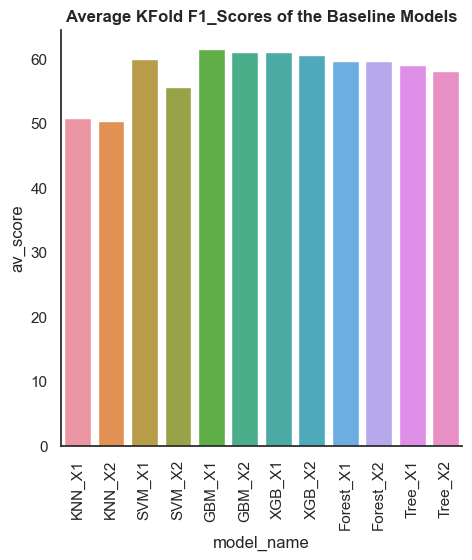

In [13]:
sns.set(style='white', color_codes=True)

ax=sns.catplot(x='model_name',y='av_score', kind='bar', data=models_df)
plt.title("Average KFold F1_Scores of the Baseline Models", weight='bold')
ax.set_xticklabels(rotation=90);